In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import numpy as np
from production import Problem, Worldline, local_move

In [3]:
rng = np.random.default_rng()

In [55]:
pb = Problem(
    n_sites=10,
    J_x=10.,
    J_z=1.,
    temperature=1,
    m=6
)

In [56]:
pb.calculate_general_probabilities()

{'S1': {'G1': np.float64(0.49519500255305343),
  'G2': np.float64(0.5048049974469466),
  'G3': np.float64(0.0)},
 'S2': {'G2': np.float64(0.7398992654575087),
  'G4': np.float64(0.2601007345424912),
  'G3': np.float64(0.0)},
 'S3': {'G1': np.float64(0.7361832763705075),
  'G4': np.float64(0.26381672362949266),
  'G3': np.float64(0.0)}}

In [5]:
A = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]])
b = np.array([pb.weight_side, pb.weight_cross, pb.weight_full])

w = np.linalg.inv(A) @ b


In [41]:
class GridUnionFind:
    def __init__(self, m, n):
        # Grid dimensions: height is 2*m, width is n
        self.rows = 2 * m
        self.cols = n
        
        size = self.rows * self.cols
        self.parent = list(range(size))
        self.rank = [0] * size

    def _get_index(self, r, c):
        """Helper to convert 2D (row, col) to 1D index."""
        if not (0 <= r < self.rows and 0 <= c < self.cols):
             raise ValueError(f"Coordinate ({r}, {c}) out of bounds.")
        return r * self.cols + c

    def find(self, r, c):
        """Finds the representative of the cell (r, c)."""
        i = self._get_index(r, c)
        
        if self.parent[i] != i:
            # Path Compression
            self.parent[i] = self._find_by_index(self.parent[i])
        return self.parent[i]

    def _find_by_index(self, i):
        """Internal find helper for path compression recursion."""
        if self.parent[i] != i:
            self.parent[i] = self._find_by_index(self.parent[i])
        return self.parent[i]

    def union(self, r1, c1, r2, c2):
        """Unions the sets containing cells (r1, c1) and (r2, c2)."""
        # Convert coordinates to indices
        i = self._get_index(r1, c1)
        j = self._get_index(r2, c2)
        
        # Find roots using internal index logic
        root_i = self._find_by_index(i)
        root_j = self._find_by_index(j)

        if root_i != root_j:
            # Union by Rank
            if self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            elif self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            return True
        return False

    def get_ensembles(self):
        """
        Returns a list of lists, where each inner list contains 
        the (r, c) coordinates of a connected component.
        """
        from collections import defaultdict
        
        # Dictionary to group cells by their root ID
        groups = defaultdict(list)
        
        for r in range(self.rows):
            for c in range(self.cols):
                # find(r, c) returns the unique ID of the set this cell belongs to
                root_id = self.find(r, c)
                groups[root_id].append((r, c))
        
        # Return just the lists of coordinates (the values of the dict)
        return list(groups.values())

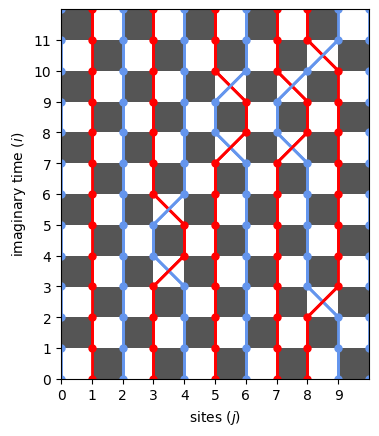

In [65]:
n = pb.n_sites
m = pb.m

spins = np.ones((2*m, n))
for i in range(0, n, 2):
    spins[:, i] *= -1
wl = Worldline(pb, spins)
for _ in range(5_000):
    local_move(wl, rng)
wl.draw()

In [66]:
pb.calculate_general_probabilities()

{'S1': {'G1': np.float64(0.49519500255305343),
  'G2': np.float64(0.5048049974469466),
  'G3': np.float64(0.0)},
 'S2': {'G2': np.float64(0.7398992654575087),
  'G4': np.float64(0.2601007345424912),
  'G3': np.float64(0.0)},
 'S3': {'G1': np.float64(0.7361832763705075),
  'G4': np.float64(0.26381672362949266),
  'G3': np.float64(0.0)}}

In [67]:
from production.utils import draw_key

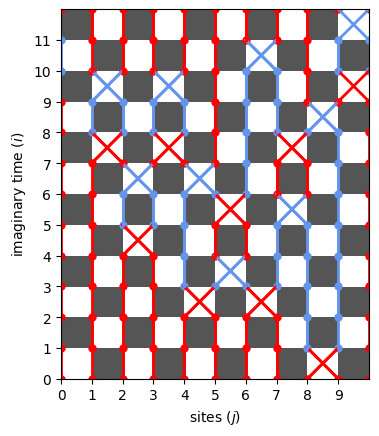

2


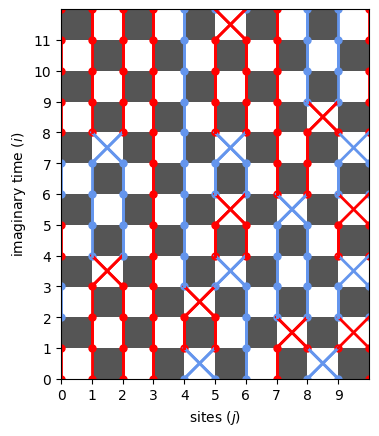

In [ ]:
n = pb.n_sites
m = pb.m

spins = wl.spins

uf = GridUnionFind(m, n)

probs = pb.calculate_general_probabilities()

for j in range(2*m):
    for base_i in range(n//2):
        i = 2 * base_i + (j%2)

        j_plus = (j + 1) % (2 * m)
        i_plus = (i + 1) % n

        if spins[j, i] != spins[j_plus, i]: # cross
            key = draw_key(probs["S2"], rng)
            if key == "G2":
                # print(f"{i},{j} -> 2 ({probs["S2"]["G2"]})")
                uf.union(j, i, j, i_plus)
                uf.union(j_plus, i, j_plus, i_plus)
            elif key == "G4":
                # print(f"{i},{j} -> 4 ({probs["S2"]["G4"]})")
                uf.union(j, i, j_plus, i_plus)
                uf.union(j, i_plus, j_plus, i)
            else:
                print("aïe G3")
        elif spins[j, i] != spins[j, i_plus]: # side
            key = draw_key(probs["S1"])
            if key == "G1":
                # print(f"{i},{j} -> 1 ({probs["S1"]["G1"]})")
                uf.union(j, i, j_plus, i)
                uf.union(j, i_plus, j_plus, i_plus)
            elif key == "G2":
                # print(f"{i},{j} -> 2 ({probs["S1"]["G2"]})")
                uf.union(j, i, j_plus, i_plus)
                uf.union(j, i_plus, j_plus, i)
            else:
                print("aïe G3")
        else: # full
            key = draw_key(probs["S3"])
            if key == "G1":
                # print(f"{i},{j} -> 1 ({probs["S3"]["G1"]})")
                uf.union(j, i, j_plus, i)
                uf.union(j, i_plus, j_plus, i_plus)
            elif key == "G4":
                # print(f"{i},{j} -> 4 ({probs["S3"]["G4"]})")
                uf.union(j, i, j, i_plus)
                uf.union(j_plus, i, j_plus, i_plus)
            else:
                print("aïe G3")

loop_changed = 0
for loop in uf.get_ensembles():
    if rng.random() < 0.5:
        loop_changed += 1
        # print(loop)
        for (j, i) in loop:
            spins[j, i] *= -1

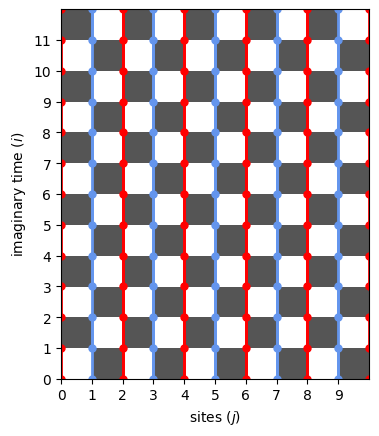